In [1]:
import pandas as pd
import mysql
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import mysql
from mysql.connector import MySQLConnection, Error
import time
from datetime import datetime, time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load





from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [2]:
df = pd.DataFrame()
def query_with_fetchall():
    try:
        connection = mysql.connector.connect(user='brett', 
                                             password='BrettTully#2023',
                                             host='r2klabs.com',
                                             database='sensor')
        cursor = connection.cursor()
        cursor.execute("SELECT * FROM rpisense order by sensor_date DESC;")
        rows = cursor.fetchall()
        print('Total Row(s):', cursor.rowcount)
        title = [i[0] for i in cursor.description]
        print(title)
        global df
        df = pd.DataFrame(rows)
        df['time'] = df[1].dt.time
        df['weekday'] = df[1].dt.weekday
        df['date'] = df[1].dt.date
        #df.to_csv("sensordata.csv",index=False)
    except Error as e:
        print(e)
    finally:
        cursor.close()
        connection.close()
query_with_fetchall()

df.rename(columns={0:"Device",1:"Datetime",2:"Temp F",3:"Humidity","time":"Time","weekday":"Weekday","date":"Date"},inplace=True)        



################## Creating the dictionary that contains the class times  ################################################################################


occupied_times = {
    "P002": {
        "0": [("09:00:00","09:50:00"),("10:00:00","10:50:00") ,("13:00:00","13:50:00")],
        "1": [("09:00:00", "11:00:00"),("12:15:00","13:30:00")],
        "2": [("09:00:00","9:50:00"),("10:00:00","10:50:00"), ("13:00:00","13:50:00")],
        "3": [("11:00:00","12:15:00"),("13:30:00","15:40:00")],
        "4": [("09:00:00","09:50:00"),("10:00:00","10:50:00")]
    },
    "P004": {
        "0": [("09:00:00","09:50:00"),("10:00:00","10:50:00")],
        "1": [("08:40:00","10:40:00"),("12:15:00", "13:30:00"), ("13:40:00","14:50:00")],
        "2": [("09:00:00","09:50:00"),("10:00:00","10:50:00")],
        "3": [("08:40:00","10:40:00"),("12:15:00", "13:30:00"),("13:40:00","14:50:00")],
        "4": [("09:00:00","09:50:00"),("10:00:00","10:50:00")]
    },
    "P006B": {
        "1": [("10:00:00", "12:00:00")],
        "2": [("10:00:00", "12:00:00")],
        "3": [("10:00:00", "12:00:00")],
        "4": [("10:00:00", "12:00:00")],
        "5": [("10:00:00", "12:00:00")]
    }
}

flattened = []



# turning the dictionary into a dataframe

for room, room_sessions in occupied_times.items(): 
    for dow, session_windows in room_sessions.items():
        for session_window in session_windows: 
            flattened.append([room,dow,session_window[0],
                             session_window[1]])
room_times = pd.DataFrame(flattened, columns =['Device','Weekday','Start Time','End Time'])           
room_times.to_csv('room_times.csv')


df = df.reset_index(drop=True)
room_times = room_times.reset_index(drop=True)

df = df.sample(1000)

df['Time'] = df['Time'].astype(str)
df['Device'] = df['Device'].astype(str)
room_times['Weekday'] = room_times['Weekday'].astype('int64')
room_times['Start Time'] = room_times['Start Time'].astype(str)
room_times['End Time'] = room_times['End Time'].astype(str)
room_times['Device'] = room_times['Device'].astype(str)




############MODEL################################################################################

Total Row(s): 4939900
['device', 'sensor_date', 'temp', 'humidity']


# Assigning a 1 or 0 based on whether the class was actually in session

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Convert start_time and end_time columns to time objects
room_times['Start Time'] = room_times['Start Time'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time())
room_times['End Time'] = room_times['End Time'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time())




# Convert time_stamp column to time objects and check if it falls between any of the time ranges on the specified days of the week and room numbers
df['Time'] = df['Time'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time())

# Create new columns in the time_stamps_df DataFrame called 'in_range' and 'room_number', and initialize them to 0 and None, respectively
df['in_use'] = 0


# Iterate through each row in the time_stamps_df DataFrame, and for each row we iterate through each row in the df DataFrame to check if the time stamp falls between any of the time ranges on the specified days of the week and room numbers. If the time stamp falls between any of the time ranges on the specified day of the week and room number, we set the value of 'in_range' to 1 and the value of 'room_number' to the corresponding room number using the at() method.

for index, row in df.iterrows():
    for index2, row2 in room_times.iterrows():
        if row2['Weekday'] == row['Weekday'] and row2['Device'] == row['Device']:
            if row2['Start Time'] <= row['Time'] <= row2['End Time']:
                df.at[index, 'in_use'] = 1
                break       


                
                
             

# Exploratory Data Analysis

# Data Types

In [4]:
df.dtypes

Device              object
Datetime    datetime64[ns]
Temp F             float64
Humidity           float64
Time                object
Weekday              int64
Date                object
in_use               int64
dtype: object

# Summary Statistics

In [5]:
# I have to use a lambda function as my statistics would come in as scientific notation normally
df["Temp F"].describe().apply(lambda x: format(x, 'f'))

count    1000.000000
mean       67.981280
std         2.200957
min        59.360000
25%        66.920000
50%        68.000000
75%        68.900000
max        79.700000
Name: Temp F, dtype: object

In [6]:
df["Humidity"].describe().apply(lambda x: format(x, 'f'))

count    1000.000000
mean       46.855700
std        13.592370
min        17.100000
25%        36.400000
50%        45.300000
75%        56.000000
max        88.200000
Name: Humidity, dtype: object

# Categorical Variable Proportions

In [7]:
df['Device'].value_counts()

P004     360
P002     349
P006B    291
Name: Device, dtype: int64

# Correlation Table

In [8]:
corr_table = df.corr()

corr_table

/var/folders/6v/g08h247s4ls5ybhd8f_3f6m80000gn/T/ipykernel_21669/3038341242.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_table = df.corr()


,Temp F,Humidity,Weekday,in_use
Temp F,1.000000,0.014560,0.074728,0.025083
Humidity,0.014560,1.000000,0.074027,0.036759
Weekday,0.074728,0.074027,1.000000,-0.113250
in_use,0.025083,0.036759,-0.113250,1.000000


[Text(0.5, 1.0, 'Heatmap of Temp F and Humidity')]

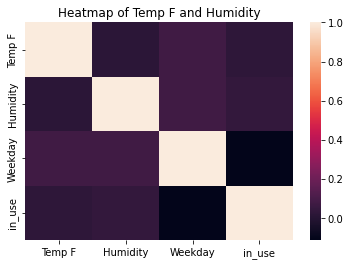

In [9]:
sns.heatmap(corr_table).set(title='Heatmap of Temp F and Humidity')

In [10]:
days = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
df['Weekday'] = df['Weekday'].apply(lambda x: days[x])

(0.0, 100.0)

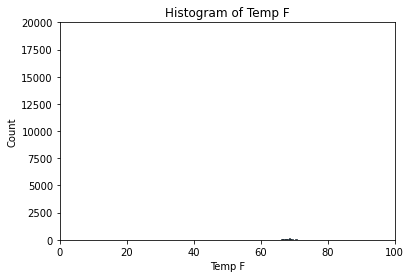

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(data=df, x="Temp F").set(title='Histogram of Temp F')
plt.ylim(0,20000)
plt.xlim(0, 100)

[Text(0.5, 1.0, 'Histogram of Humidity')]

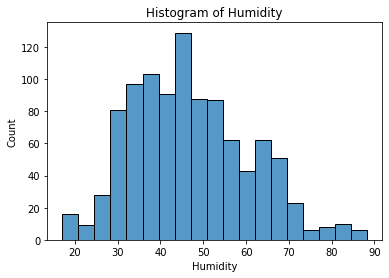

In [12]:
sns.histplot(data=df, x="Humidity").set(title='Histogram of Humidity')

(0.0, 100.0)

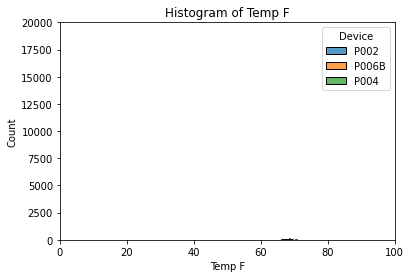

In [13]:
sns.histplot(data=df, x="Temp F", hue="Device", multiple="stack").set(title='Histogram of Temp F')
plt.ylim(0,20000)
plt.xlim(0, 100)

(0.0, 100.0)

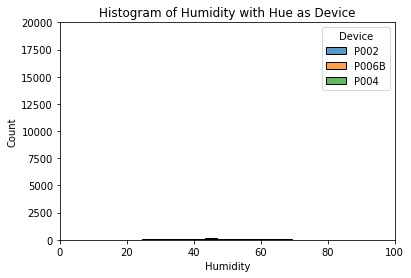

In [14]:
sns.histplot(data=df, x="Humidity", hue="Device", multiple="stack").set(title='Histogram of Humidity with Hue as Device')
plt.ylim(0,20000)
plt.xlim(0, 100)

[Text(0.5, 1.0, 'Histogram of Humidity with Hue as Weekday')]

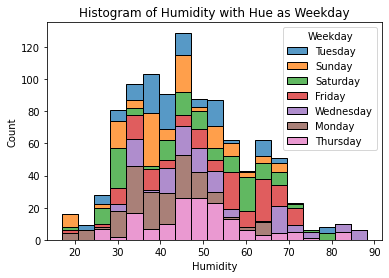

In [15]:
sns.histplot(data=df, x="Humidity", hue="Weekday", multiple="stack").set(title='Histogram of Humidity with Hue as Weekday')

[Text(0.5, 1.0, 'Histogram of Humidity with Hue as Device')]

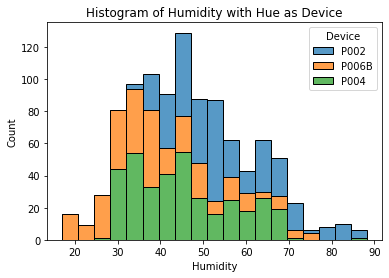

In [16]:
sns.histplot(data=df, x="Humidity", hue="Device", multiple="stack").set(title='Histogram of Humidity with Hue as Device')

[Text(0.5, 1.0, 'Line Plot of Temp F with Hue as Device')]

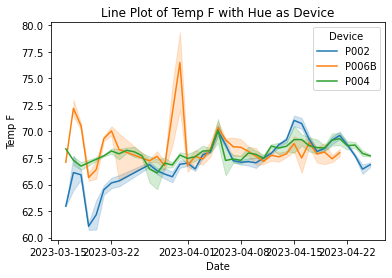

In [17]:
sns.lineplot(data=df, x="Date", y="Temp F",hue='Device').set(title='Line Plot of Temp F with Hue as Device')

[Text(0.5, 1.0, 'Line Plot of Humidity with Hue as Device')]

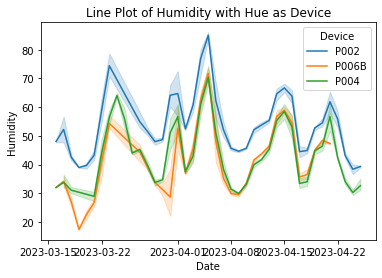

In [18]:
sns.lineplot(data=df, x="Date", y="Humidity",hue='Device').set(title='Line Plot of Humidity with Hue as Device')

[Text(0.5, 1.0, 'Scatterplot of Humidity and Temp F')]

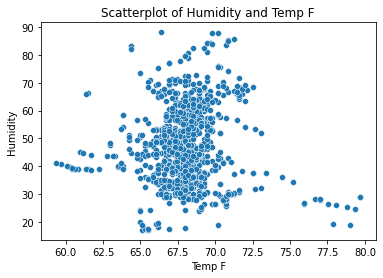

In [19]:
sns.scatterplot(data=df, x="Temp F", y="Humidity").set(title='Scatterplot of Humidity and Temp F')


(0.0, 100.0)

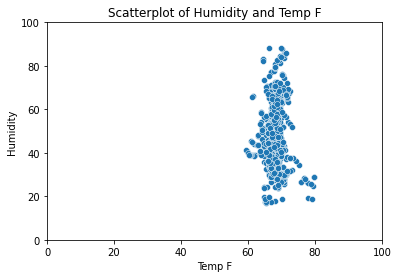

In [20]:
sns.scatterplot(data=df, x="Temp F", y="Humidity").set(title='Scatterplot of Humidity and Temp F')
plt.xlim(0,100)
plt.ylim(0, 100)

[Text(0.5, 1.0, 'Boxplot of Humidity/Weekday with Hue as Device')]

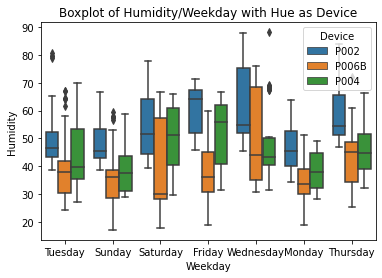

In [21]:

sns.boxplot(data=df, x="Weekday", y="Humidity",hue="Device").set(title='Boxplot of Humidity/Weekday with Hue as Device')

[Text(0.5, 1.0, 'Boxplot of Humidity/Weekday')]

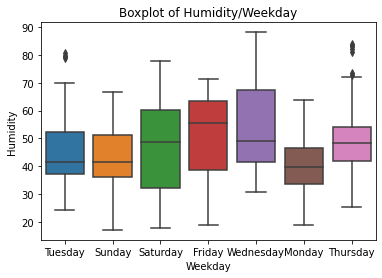

In [22]:
sns.boxplot(data=df, x="Weekday", y="Humidity").set(title='Boxplot of Humidity/Weekday')

[Text(0.5, 1.0, 'Boxplot of Humidity/Device')]

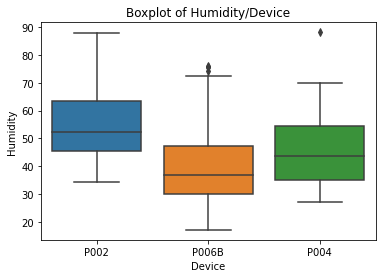

In [23]:
sns.boxplot(data=df, x="Device", y="Humidity").set(title='Boxplot of Humidity/Device')

[Text(0.5, 1.0, 'Boxplot of Humidity/Device with hue as Weekday')]

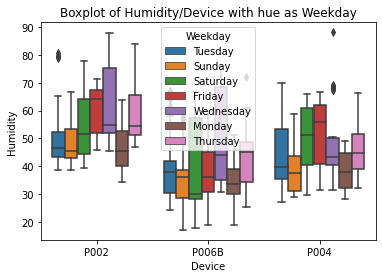

In [24]:
sns.boxplot(data=df, x="Device", y="Humidity",hue="Weekday").set(title='Boxplot of Humidity/Device with hue as Weekday')

[Text(0.5, 1.0, 'Boxplot of Humidity/Device')]

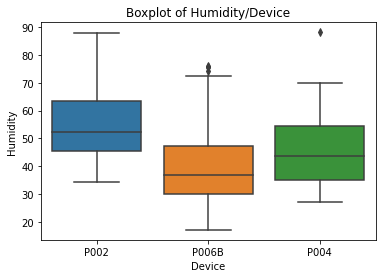

In [25]:
sns.boxplot(data=df, x="Device", y="Humidity").set(title='Boxplot of Humidity/Device')

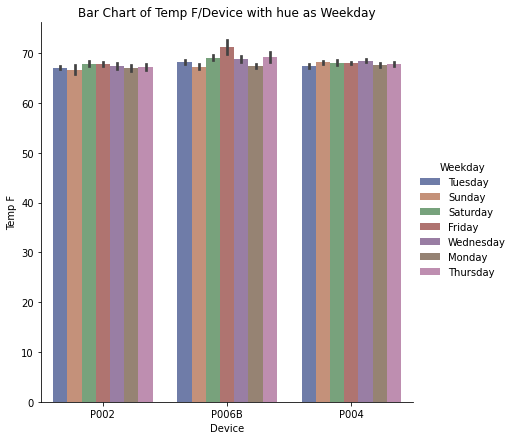

In [26]:
sns.catplot(
    data=df, kind="bar",
    x="Device", y="Temp F", hue="Weekday",palette="dark", alpha=.6, height=6).set(title='Bar Chart of Temp F/Device with hue as Weekday')

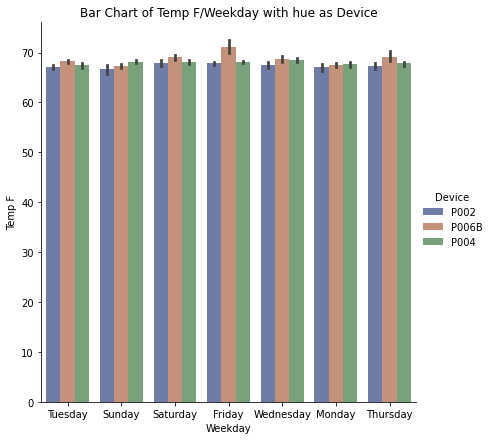

In [27]:
sns.catplot(
    data=df, kind="bar",
    x="Weekday", y="Temp F", hue="Device",palette="dark", alpha=.6, height=6
).set(title='Bar Chart of Temp F/Weekday with hue as Device')

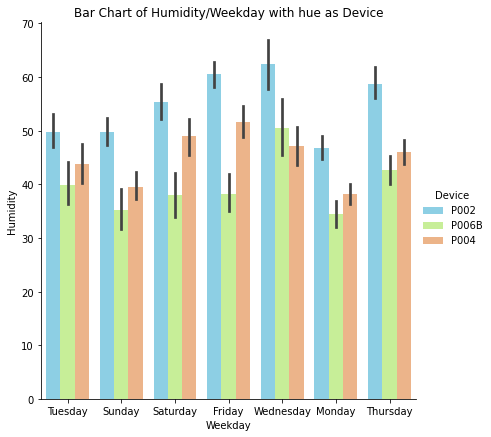

In [28]:
sns.catplot(
    data=df, kind="bar",
    x="Weekday", y="Humidity", hue="Device",palette="turbo", alpha=.6, height=6).set(title='Bar Chart of Humidity/Weekday with hue as Device')

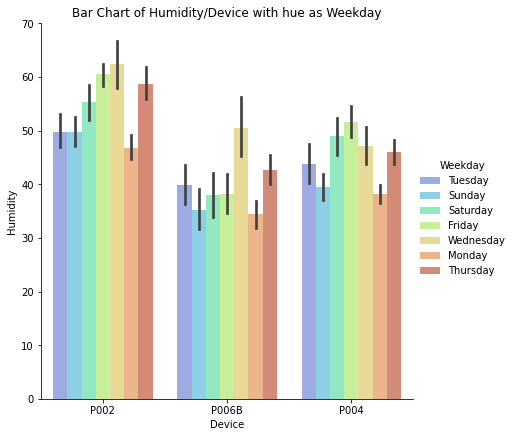

In [29]:
sns.catplot(
    data=df, kind="bar",
    x="Device", y="Humidity", hue="Weekday",palette="turbo", alpha=.6, height=6
).set(title='Bar Chart of Humidity/Device with hue as Weekday')